#Generate clips
Generate 2-sec + call length clips along with mask files (0's where no call, 1's where call) and save to use as training data. Use all labeled files in round 1.

Output clips to /content/drive/My Drive/MeerkatCallDetector/clips

Save in format:
calltype##_aud.npy
calltype##_mask.npy

In [33]:
#Generate samples for use as training data
#Generate files and store in clips folder

#params
base_dir = '/home/arianasp/meerkat_detector'
ari_labels_only = False
load_labels = True
generate_clips = True
focal = False #whether to run for focal obs recordings from collaring experiment (otherwise run for collar recordings)
focal_megan = True #whether to run on focal obs recordings collected from Megan

#Directories
ground_truth_dir = base_dir + '/ground_truth'
code_dir = base_dir + '/dev'
audio_dir = base_dir + '/data/full_recordings' 
focal_megan_dir = '/media/arianasp/Elements/Sound files/Pups VS No Pups'

#Leave one file out for later validation
#validation_file = 'HM_PET_R11_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221163_SS' #used for collar data
validation_file = 'HM_VHMM003_SOUNDFOC_20170905_3_label' #used for focal data

#import libraries
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import re
import IPython.display as ipd

#Set path
sys.path.append(code_dir)

#Import library
from meerkat_call_detector_library import *

if(load_labels and not focal_megan):

  #Read in all training data
  ground_truth_files = os.listdir(ground_truth_dir)

  #Remove sound focals or use only sound focals
  if(focal):
    #ground_truth_files = [s for s in ground_truth_files if('SOUNDFOC' in s)]
    ground_truth_files = [s for s in ground_truth_files if('SOUNDFOC' in s)]
  else:
    ground_truth_files = [s for s in ground_truth_files if(not('SOUNDFOC' in s))]
  print(ground_truth_files)
    
  #Remove data from validation file (will be used later)
  ground_truth_files = [s for s in ground_truth_files if(not(validation_file in s))]

  #Remove files lableed by other peoples (to use as testing data)
  if(ari_labels_only):
    ground_truth_files = [s for s in ground_truth_files if(("label.csv" in s) or ('label.CSV' in s))]

  labels_all = pandas.DataFrame()

  for file in ground_truth_files:

    #Read in curent labels for each file
    labels = pandas.read_csv(ground_truth_dir + '/' + file,delimiter='\t')

    #convert times to seconds
    labels['start_time'] = labels['Start'].map(lambda x: hms_to_seconds(x))
    labels['duration'] = labels['Duration'].map(lambda x: hms_to_seconds(x))
    labels['end_time'] = labels['start_time'] + labels['duration']

    #Add columns for label types
    labels['label_type'] = labels['Name'].apply(label_type)
    labels['call_type'] = labels['Name'].apply(call_type_simple)
    labels['focal'] = labels['Name'].apply(caller)

    #Add column for filename
    labels['file'] = file

    #Add None where appropriate
    labels.loc[labels['label_type'] != 'call','call_type'] = None
    labels.loc[labels['label_type'] != 'call','focal'] = None

    labels_all = labels_all.append(labels,ignore_index=True)

  labels = labels_all
  
if(generate_clips and not(focal_megan)):

  #generate 2 sec clips and save to clips folder
  if(focal):
    clips_dir = base_dir + '/clips_foc'
  elif(focal_megan):
    clips_dir = base_dir + '/clips_foc_megan'
  else:
    clips_dir = base_dir + '/clips'
  samprate = 8000 

  n_labels = len(labels.index)

  for i in labels.index:
    print(str(i) + '/' + str(n_labels))
    call_type = labels['call_type'][i]
    if(call_type != None):
        t0 = labels['start_time'][i] - 1
        tf = labels['end_time'][i] + 1
        file = labels['file'][i]
        
        if(focal):
          path_aud = audio_dir + '/' + file[0:(len(file)-4)] + '_downsamp.wav'
        else:
          path_aud = audio_dir + '/' + file[0:(len(file)-4)] + '.wav'
        aud, sr = librosa.core.load(path=path_aud,sr=samprate,offset=t0,duration=tf-t0)

        #get mask
        labs_curr = labels[(labels['file']==file) & (labels['start_time']>= t0) & (labels['end_time']<= tf) & (labels['call_type']!= None)]
        nrow = labs_curr.shape[0]
        mask = np.zeros(shape=len(aud))
        for j in labs_curr.index:
          t0_call = np.int(np.round((labs_curr['start_time'][j] - t0)*samprate))
          tf_call = np.int(np.round((labs_curr['end_time'][j] - t0)*samprate))
          if(t0_call < 0):
            t0_call = 0
          mask[t0_call:tf_call] = 1
        clip_file_name = call_type + str(i)
        np.save(clips_dir + '/' + clip_file_name + '_mask.npy',mask)
        np.save(clips_dir + '/' + clip_file_name + '_aud.npy',aud)

  #save list of labels
  fid = open(clips_dir + '/' + 'labels_all.pckl','wb')
  pickle.dump(labels,fid)
  fid.close()

if(generate_clips and focal_megan):
    labels_train_file = '/home/arianasp/meerkat_detector/labels_megan/focal_labels_train.csv'
    wav_dir = '/media/arianasp/Elements/Sound Files/Pups VS No Pups'
    clips_dir = '/home/arianasp/meerkat_detector/clips_foc_megan'
    samprate=8000
    labels = pandas.read_csv(labels_train_file,delimiter=',')

    #Convert European formatted numbers to decimal format
    labels["t0"] = labels["t0"].str.replace(",",".").astype(float)
    labels["tf"] = labels["tf"].str.replace(",",".").astype(float)

    #Loop over all labels and create clips and masks for each
    for i in range(labels.shape[0]):
        print(i)
        filename = labels['filename'][i]
        call_type = labels['type'][i]
        t0 = float(labels['t0'][i]) - 1
        tf = float(labels['tf'][i]) + 1
        iscall = labels['iscall'][i]
        if iscall:
            file_str = filename[0:(len(filename)-4)]
            matches = glob.glob(wav_dir + '/**/' + file_str + '_LEFT_8000.[wW][aA][vV]',recursive=True)
            if len(matches)==1 and t0>0:
                path_aud = matches[0]
                aud, sr = librosa.core.load(path=path_aud,sr=samprate,offset=t0,duration=tf-t0)
                labs_curr = labels[(labels['filename']==filename) & (labels['t0']>= t0) & (labels['tf']<= tf) & (labels['iscall']== True)]
                if (sum(labs_curr['type'].str.contains('end'))==0) and (sum(labs_curr['type'].str.contains('start'))==0):
                    nrow = labs_curr.shape[0]
                    mask = np.zeros(shape=len(aud))
                    for j in labs_curr.index:
                      t0_call = np.int(np.round((labs_curr['t0'][j] - t0)*samprate))
                      tf_call = np.int(np.round((labs_curr['tf'][j] - t0)*samprate))
                      if(t0_call < 0):
                        t0_call = 0
                      mask[t0_call:tf_call] = 1
                    clip_file_name = call_type + str(i)
                    np.save(clips_dir + '/' + clip_file_name + '_mask.npy',mask)
                    np.save(clips_dir + '/' + clip_file_name + '_aud.npy',aud)

['HM_VHMM003_SOUNDFOC_20170905_3_label.csv', 'HM_VHMM003_SOUNDFOC_20170905_2_label.CSV', 'HM_VHMM003_SOUNDFOC_20170905_4_label.csv', 'HM_VLF206_SOUNDFOC_20170905_1_labelSS.csv', 'HM_VLF206_SOUNDFOC_20170823_2_LABEL_RY.csv', 'HM_VLF206_SOUNDFOC_20170824_1_labelSS.csv', 'HM_VLF206_SOUNDFOC_20170823_1_LABEL_RY.csv', 'HM_VLF206_SOUNDFOC_20170905_2_labelSS.csv', 'HM_VHMM003_SOUNDFOC_20170825_2_label.csv', 'HM_VHMM003_SOUNDFOC_20170825_3_label.csv', 'HM_VLF206_SOUNDFOC_20170825_2_label.csv', 'HM_VLF206_SOUNDFOC_20170806_3_label.csv', 'HM_VLF206_SOUNDFOC_20170806_4_label.csv', 'HM_VLF206_SOUNDFOC_20170825_1_label.csv', 'HM_VHMM003_SOUNDFOC_20170824_2_LABEL_RY.csv', 'HM_VLF206_SOUNDFOC_20170824_2_labelSS.csv', 'HM_VLF206_SOUNDFOC_20170903_LABEL_RY.csv', 'HM_VLF206_SOUNDFOC_20170806_2_label.csv']
0/4957
1/4957
2/4957
3/4957
4/4957
5/4957
6/4957
7/4957
8/4957
9/4957
10/4957
11/4957
12/4957
13/4957
14/4957
15/4957
16/4957
17/4957
18/4957
19/4957
20/4957
21/4957
22/4957
23/4957
24/4957
25/4957
26/

834/4957
835/4957
836/4957
837/4957
838/4957
839/4957
840/4957
841/4957
842/4957
843/4957
844/4957
845/4957
846/4957
847/4957
848/4957
849/4957
850/4957
851/4957
852/4957
853/4957
854/4957
855/4957
856/4957
857/4957
858/4957
859/4957
860/4957
861/4957
862/4957
863/4957
864/4957
865/4957
866/4957
867/4957
868/4957
869/4957
870/4957
871/4957
872/4957
873/4957
874/4957
875/4957
876/4957
877/4957
878/4957
879/4957
880/4957
881/4957
882/4957
883/4957
884/4957
885/4957
886/4957
887/4957
888/4957
889/4957
890/4957
891/4957
892/4957
893/4957
894/4957
895/4957
896/4957
897/4957
898/4957
899/4957
900/4957
901/4957
902/4957
903/4957
904/4957
905/4957
906/4957
907/4957
908/4957
909/4957
910/4957
911/4957
912/4957
913/4957
914/4957
915/4957
916/4957
917/4957
918/4957
919/4957
920/4957
921/4957
922/4957
923/4957
924/4957
925/4957
926/4957
927/4957
928/4957
929/4957
930/4957
931/4957
932/4957
933/4957
934/4957
935/4957
936/4957
937/4957
938/4957
939/4957
940/4957
941/4957
942/4957
943/4957
944/4957
9

1670/4957
1671/4957
1672/4957
1673/4957
1674/4957
1675/4957
1676/4957
1677/4957
1678/4957
1679/4957
1680/4957
1681/4957
1682/4957
1683/4957
1684/4957
1685/4957
1686/4957
1687/4957
1688/4957
1689/4957
1690/4957
1691/4957
1692/4957
1693/4957
1694/4957
1695/4957
1696/4957
1697/4957
1698/4957
1699/4957
1700/4957
1701/4957
1702/4957
1703/4957
1704/4957
1705/4957
1706/4957
1707/4957
1708/4957
1709/4957
1710/4957
1711/4957
1712/4957
1713/4957
1714/4957
1715/4957
1716/4957
1717/4957
1718/4957
1719/4957
1720/4957
1721/4957
1722/4957
1723/4957
1724/4957
1725/4957
1726/4957
1727/4957
1728/4957
1729/4957
1730/4957
1731/4957
1732/4957
1733/4957
1734/4957
1735/4957
1736/4957
1737/4957
1738/4957
1739/4957
1740/4957
1741/4957
1742/4957
1743/4957
1744/4957
1745/4957
1746/4957
1747/4957
1748/4957
1749/4957
1750/4957
1751/4957
1752/4957
1753/4957
1754/4957
1755/4957
1756/4957
1757/4957
1758/4957
1759/4957
1760/4957
1761/4957
1762/4957
1763/4957
1764/4957
1765/4957
1766/4957
1767/4957
1768/4957
1769/4957


2490/4957
2491/4957
2492/4957
2493/4957
2494/4957
2495/4957
2496/4957
2497/4957
2498/4957
2499/4957
2500/4957
2501/4957
2502/4957
2503/4957
2504/4957
2505/4957
2506/4957
2507/4957
2508/4957
2509/4957
2510/4957
2511/4957
2512/4957
2513/4957
2514/4957
2515/4957
2516/4957
2517/4957
2518/4957
2519/4957
2520/4957
2521/4957
2522/4957
2523/4957
2524/4957
2525/4957
2526/4957
2527/4957
2528/4957
2529/4957
2530/4957
2531/4957
2532/4957
2533/4957
2534/4957
2535/4957
2536/4957
2537/4957
2538/4957
2539/4957
2540/4957
2541/4957
2542/4957
2543/4957
2544/4957
2545/4957
2546/4957
2547/4957
2548/4957
2549/4957
2550/4957
2551/4957
2552/4957
2553/4957
2554/4957
2555/4957
2556/4957
2557/4957
2558/4957
2559/4957
2560/4957
2561/4957
2562/4957
2563/4957
2564/4957
2565/4957
2566/4957
2567/4957
2568/4957
2569/4957
2570/4957
2571/4957
2572/4957
2573/4957
2574/4957
2575/4957
2576/4957
2577/4957
2578/4957
2579/4957
2580/4957
2581/4957
2582/4957
2583/4957
2584/4957
2585/4957
2586/4957
2587/4957
2588/4957
2589/4957


3311/4957
3312/4957
3313/4957
3314/4957
3315/4957
3316/4957
3317/4957
3318/4957
3319/4957
3320/4957
3321/4957
3322/4957
3323/4957
3324/4957
3325/4957
3326/4957
3327/4957
3328/4957
3329/4957
3330/4957
3331/4957
3332/4957
3333/4957
3334/4957
3335/4957
3336/4957
3337/4957
3338/4957
3339/4957
3340/4957
3341/4957
3342/4957
3343/4957
3344/4957
3345/4957
3346/4957
3347/4957
3348/4957
3349/4957
3350/4957
3351/4957
3352/4957
3353/4957
3354/4957
3355/4957
3356/4957
3357/4957
3358/4957
3359/4957
3360/4957
3361/4957
3362/4957
3363/4957
3364/4957
3365/4957
3366/4957
3367/4957
3368/4957
3369/4957
3370/4957
3371/4957
3372/4957
3373/4957
3374/4957
3375/4957
3376/4957
3377/4957
3378/4957
3379/4957
3380/4957
3381/4957
3382/4957
3383/4957
3384/4957
3385/4957
3386/4957
3387/4957
3388/4957
3389/4957
3390/4957
3391/4957
3392/4957
3393/4957
3394/4957
3395/4957
3396/4957
3397/4957
3398/4957
3399/4957
3400/4957
3401/4957
3402/4957
3403/4957
3404/4957
3405/4957
3406/4957
3407/4957
3408/4957
3409/4957
3410/4957


4131/4957
4132/4957
4133/4957
4134/4957
4135/4957
4136/4957
4137/4957
4138/4957
4139/4957
4140/4957
4141/4957
4142/4957
4143/4957
4144/4957
4145/4957
4146/4957
4147/4957
4148/4957
4149/4957
4150/4957
4151/4957
4152/4957
4153/4957
4154/4957
4155/4957
4156/4957
4157/4957
4158/4957
4159/4957
4160/4957
4161/4957
4162/4957
4163/4957
4164/4957
4165/4957
4166/4957
4167/4957
4168/4957
4169/4957
4170/4957
4171/4957
4172/4957
4173/4957
4174/4957
4175/4957
4176/4957
4177/4957
4178/4957
4179/4957
4180/4957
4181/4957
4182/4957
4183/4957
4184/4957
4185/4957
4186/4957
4187/4957
4188/4957
4189/4957
4190/4957
4191/4957
4192/4957
4193/4957
4194/4957
4195/4957
4196/4957
4197/4957
4198/4957
4199/4957
4200/4957
4201/4957
4202/4957
4203/4957
4204/4957
4205/4957
4206/4957
4207/4957
4208/4957
4209/4957
4210/4957
4211/4957
4212/4957
4213/4957
4214/4957
4215/4957
4216/4957
4217/4957
4218/4957
4219/4957
4220/4957
4221/4957
4222/4957
4223/4957
4224/4957
4225/4957
4226/4957
4227/4957
4228/4957
4229/4957
4230/4957


4951/4957
4952/4957
4953/4957
4954/4957
4955/4957
4956/4957


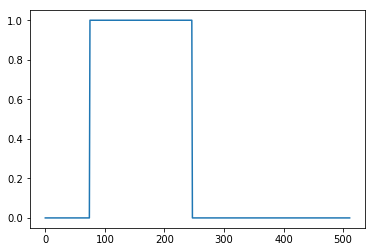

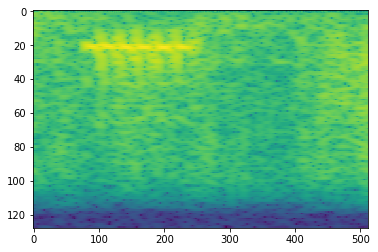

In [23]:
files = os.listdir(clips_dir)
X,y = generate_sample_call(files,clips_dir,call_type=None,mel=False)
plt.plot(y)
plt.show()
plt.imshow(X.T,aspect='auto')
plt.show()

In [31]:
print(ground_truth_files[11])

HM_VLF206_SOUNDFOC_20170806_3_label.csv


In [ ]:
/home/arianasp/meerkat_detector/data/full_recordings/HM_VHMM003_SOUNDFOC_20170905_3_label_downsamp.wav